[In English](../use-case_skewt_en/)  

![ECCC logo](https://eccc-msc.github.io/open-data/img_eccc-logo.png)  

[Tdm](https://eccc-msc.github.io/open-data/readme_fr/) > [Aperçu de l'utilisation](https://eccc-msc.github.io/open-data/usage/readme_fr/) > Requêtes WMS en Python

# Cas d'utilisation : traçage de profils verticaux basés sur les données ouvertes

## Introduction

Les données météorologiques, climatiques et hydrométriques des services web géospatiaux [GeoMet du SMC](https://eccc-msc.github.io/open-data/msc-geomet/readme_fr/) peuvent aisément être utilisées pour prévoir la demande associée à certains produits ou services. Cet exemple de cas d'utilisation montre comment extraire et traiter les données de radiosondage brutes à l'aide du langage de programmation [Python](https://www.python.org/) afin de créer un outil permettant de tracer et d'afficher des informations en fonction des données fournies. La version interactive est beaucoup plus complète et dispose d'une interface (lien ci-dessous), mais le code est très complexe et cet exemple plus simple a été conçu comme un outil d'enseignement. Il permet d'apprendre comment :
* Accéder aux données de radiosondage brutes de GeoMet du SMC et les interroger;
* Effectuer des requêtes pour obtenir les données d'une couche spécifique à un lieu précis; 
* Effectuer des requêtes temporelles;
* Afficher les résultats sous forme de graphique et de tableau.

La [version simple (cette version) de ce Jupyter Notebook est disponible ici](https://mybinder.org/v2/gh/PhilippeTh/open-data/Gerald_SkewT_Use_case_PT?labpath=%2Fdocs%2Fusage%2Fuse-case_skewt%2Fuse-case_skewt_fr.ipynb).

[![badge](https://img.shields.io/badge/Version%20simple-binder-579ACA.svg?logo=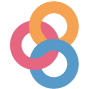)](https://mybinder.org/v2/gh/PhilippeTh/open-data/Gerald_SkewT_Use_case_PT?labpath=%2Fdocs%2Fusage%2Fuse-case_skewt%2Fuse-case_skewt_fr.ipynb)

La [version interactive de ce Jupyter Notebook est disponible ici](https://mybinder.org/v2/gh/PhilippeTh/open-data/Gerald_SkewT_Use_case_PT?labpath=%2Fdocs%2Fusage%2Fuse-case_skewt%2Fuse-case_skewt-interactive_fr.ipynb).

[![badge](https://img.shields.io/badge/Version%20interactive-binder-F5A252.svg?logo=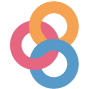)](https://mybinder.org/v2/gh/PhilippeTh/open-data/Gerald_SkewT_Use_case_PT?labpath=%2Fdocs%2Fusage%2Fuse-case_skewt%2Fuse-case_skewt-interactive_fr.ipynb)

## Creation d'un outil pour extraire et tracer les données de sonde

Considérons la situation suivante : Gérald, pilote d'avion, aimerait pouvoir accéder aux observations en altitude des données canadiennes de manière facilement compréhensible et précise. Il peut en avoir besoin à tout moment de la journée et il aimerait connaître les prévisions pour un vol à venir. Un ami lui a également dit qu'il pourrait y avoir des conditions météorologiques défavorables sur la trajectoire qu'il a choisie. Gerald aimerait donc vérifier cette information par lui-même et voir s'il doit modifier sa trajectoire ou même retarder ou annuler son vol. Gerald souhaite pouvoir obtenir les informations dont il a besoin en temps voulu en utilisant les prévisions de radiosondage obtenues auprès des services web géospatiaux de GeoMet du SMC.

Pour être en mesure de voir les données pour une heure et un lieu spécifiques, la première étape consiste à interroger le processus ``Extract Sounding Data Geomet OGC API Process`` de GeoMet du SMC pour obtenir les données associées avec le modèle, la passe du modèle, l'heure de prévision et la lat/lon par le biais de la programmation Python. Pour réaliser cette étape, les modules Python doivent d'abord être importés et des valeurs doivent être données aux paramètres de la requête. La couche utilisée pour cet exemple sera la couche du [Système global de prévision déterministe (SGPD)](https://eccc-msc.github.io/open-data/msc-data/nwp_gdps/readme_gdps_fr/) qui contient les prévisions déterministes des éléments de l'atmosphère du jour présent jusqu'à 10 jours dans le futur.

In [1]:
# Retirer cette commande si le code roule à l'extérieur d'un Jupyter Notebook.
%matplotlib widget

# Importation de modules Python.
import datetime
import logging
import math
import re
import requests

# Tous les modules suivants doivent d'abord être installés pour
# pouvoir utiliser ce code hors de ce Jupyter Notebook.
from adjustText import adjust_text
from matplotlib.font_manager import FontProperties
import matplotlib.patheffects as mpatheffects
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker

# logging utilisé uniquement afin d'enlever un avertissement Cartopy inutile de Metpy.
metpy_plot_logger = logging.getLogger('metpy.plots')
metpy_plot_logger.setLevel(logging.ERROR)
import metpy.calc as mpcalc
import metpy.interpolate as mpinterpolate
from metpy.plots import Hodograph, SkewT
from metpy.units import units

# Sert seulement à pouvoir utiliser le symbole de degré dans le titre du graphique.
DEG_SYMBOL = u'\N{DEGREE SIGN}'

# Le format horaire utilisé est UTC±00:00.
ISO_FORMAT = '%Y-%m-%dT%H:%M:%SZ'

Une fois les modules importés, nous sélectionnons ce que nous voulons voir.

In [2]:
# Choix de paramètres

# Modèle (SGPD, SRPD ou SHRPD), les noms des modèles
# sont utilisés en anglais pour les besoins du code:
equivalences_modeles = {
    "SGPD": "GDPS",
    "SRPD": "RDPS",
    "SHRPD": "HRDPS"
}
model = "SGPD"

# Les temps ci-dessous sont calculés pour que le script
# fonctionne tel quel, mais vous pouvez mettre une date
# valide de votre choix formattée comme les exemples.

# Passe de modèle:
mr_date = datetime.date.today() - datetime.timedelta(days=1)
model_run = f'{mr_date.strftime("%Y-%m-%d")}T12:00:00Z'
# ex.: model_run = '2024-01-01T12:00:00Z'

# Heure de prévision:
forecast_hour = f'003: {mr_date.strftime("%Y-%m-%d")}T15:00:00Z'
# ex.: forecast_hour = '003: 2024-01-01T15:00:00Z'

# latitude et longitude,
# (Attention à ne pas sélectionner des coordonnées qui sont en dehors du modèle choisi):
# Ici, nous sélectionnons la lat/lon correspondant à CYHZ:Halifax.
lat = 44.53
lon = -63.31

Maintenant que les paramètres ont été choisis, une requête ``POST`` doit être envoyée au processus ``extract-sounding-data OGC API - Process`` avec ces paramètres afin que les données puissent être récupérées au format ``JSON``.

In [3]:
# URL pour récupérer les informations sur les données de sondage.
url = 'https://api.weather.gc.ca/processes/extract-sounding-data/execution'

# Format dans lequel les données seront reçues.
headers = {
    "Accept": "application/json",
    "Content-Type": "application/json",
}

# Paramètres à passer pour la requête.
body = {
    "inputs": {
        "forecast_hour": forecast_hour[0:3],
        "lat": lat,
        "lon": lon,
        "model": equivalences_modeles[model],
        "model_run": model_run,
        "novalues_above_100mbar": True,
    }
}

# Faire la requête et mettre la réponse au format JSON.
# La réponse contient :
# - Pression (hPa/mbar)
# - Température (°C)
# - Température du point de rosée (°C)
# - Dépression du point de rosée (°C)
# - Vitesse du vent (noeuds)
# - Direction du vent (°)
# - CAPE, CIN (J/kg)
# - LCL, LFC, EL (m AGL)
# - LI (K)
resp = requests.post(url, json=body, headers=headers).json()

Nous allons maintenant extraire les valeurs de la réponse ``JSON`` reçue et nous allons les placer dans des listes afin qu'elles soient facilement accessibles et utilisables plus tard.

In [4]:
# Stocker les valeurs pour tracer le Skew-T et l'Hodographe dans des listes et attribuer les unités appropriées.

p = [] # Liste pour stocker les niveaux de pression.
t = [] # Liste pour stocker les températures.
td = [] # Liste pour stocker les températures de point de rosée.
ws = [] # Liste pour stocker les vitesses du vent.
wd = [] # Liste pour stocker les directions du vent.
for key, val in resp['properties'].items():
    # Rechercher les données de radiosondage à chaque niveau de pression
    # S'il y a moins de 6 paramètres, cela signifie qu'une valeur est manquante et cette boucle doit être ignorée.
    if re.search(r'(\d+)mbar', key) and len(val) == 6:
        p.append(val['pressure'])
        t.append(val['air_temperature'])
        td.append(val['dew_point_temperature'])
        ws.append(val['wind_speed'])
        wd.append(val['wind_direction'])
p *= units.hPa
t *= units.degC
td *= units.degC
ws *= units.knots
wd *= units.degrees
u, v = mpcalc.wind_components(ws, wd)

Faites de même pour les indices de convection, mais au lieu de faire seulement des listes, on crée une liste de listes et on organise les données de manière à ce qu'elles puissent être placées dans un tableau.

In [5]:
# Stocker les indices de convection dans une liste de listes pour créer un tableau par la suite.

# Les indices de convection ne sont actuellement pas disponibles pour le modèle SHRPD (HRDPS),
# donc si vous sélectionnez ce modèle, tout ce que vous verrez est "N/A" dans le tableau.

# Stocker les valeurs des indices de convection dans des listes.
cape = list(resp['properties']['CAPE'].values())
cin = list(resp['properties']['CIN'].values())
lcl = list(resp['properties']['LCL'].values())
li = list(resp['properties']['LI'].values())
lfc = list(resp['properties']['LFC'].values())
el = list(resp['properties']['EL'].values())

# Réorganiser les valeurs pour obtenir la première valeur de chaque liste dans la même ligne.
conv_indices = [list(row) for row in zip(cape, cin, lcl, li, lfc, el)]
for i, row in enumerate(conv_indices):
    for j, elem in enumerate(row):
        # Arrondir les valeurs
        if isinstance(elem, float):
            conv_indices[i][j] = round(conv_indices[i][j])

# Ajouter les unités sur la dernière ligne du tableau.
if resp['properties']['LI_unit'] == "--":
    resp['properties']['LI_unit'] = "K"
conv_indices.append(
    [resp['properties']['CAPE_unit'],
     resp['properties']['CIN_unit'],
     resp['properties']['LCL_unit'],
     resp['properties']['LI_unit'],
     resp['properties']['LFC_unit'],
     resp['properties']['EL_unit']]
)

Maintenant que toutes les données ont été organisées, nous pouvons enfin commencer à tracer des graphiques. Tout d'abord, nous allons créer un ``diagramme Skew-T Log-P`` en utilisant la librairie ``Metpy``.

L'astérisque(*) dans la légende du ``diagramme Skew-T Log-P`` signifie que ce champ a été calculé par ``Metpy``, donc si vous vous demandez pourquoi, pour certains endroits, les ``CAPE/CIN`` ne correspondent pas entre les Indices de Convection et le graphique, notez que ceux qui sont dans la table sont ceux qui viennent directement de nos données et devraient être ceux qui sont considérés comme exacts en cas de non-concordance. Vous pouvez tout de même prendre en considération les résultats de ``Metpy``, ils n'utilisent probablement tout simplement pas le même algorithme que nous. Si vous voulez voir comment ``Metpy`` calcule quelque chose ou en savoir plus sur la librairie, voici un lien vers leur [Page principale](https://www.unidata.ucar.edu/software/metpy/#:~:text=MetPy%20is%20a%20collection%20of,adding%20functionality%20specific%20to%20meteorology) et voici un lien vers l'un des [calculs de Metpy pour CAPE et CIN](https://unidata.github.io/MetPy/latest/api/generated/metpy.calc.surface_based_cape_cin.html) afin que vous puissiez voir par vous-même les possibilités et leur documentation.

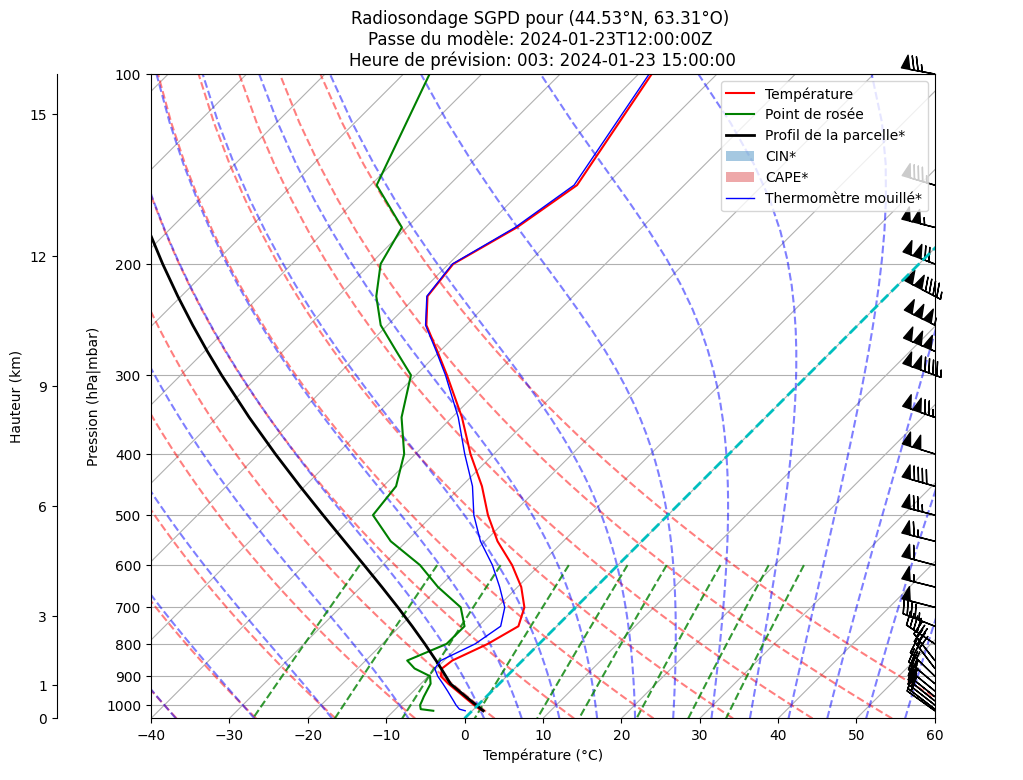

In [6]:
# Tracer un diagramme Skew-T Log-P à l'aide de la librairie Metpy.

# Cette commande empêche matplotlib de montrer le graphique où il veut,
# nous utiliserons une autre commande plus tard pour le montrer tel qu'on le souhaite.
plt.ioff()

# On commence par créer le graphique et on y ajoute les tracés.
fig = plt.figure(figsize=(10, 8), tight_layout=True)
skew = SkewT(fig, rotation=45)
skew.plot(p[:len(t)], t, 'r', label='Température')
skew.plot(p[:len(td)], td, 'g', label='Point de rosée')
skew.plot_barbs(p[:len(ws)], u, v)
skew.ax.set_ylim(1050, 100)
skew.ax.set_xlim(-40, 60)
skew.ax.xaxis.set_label_text('Température (°C)')
skew.ax.yaxis.set_label_text('Pression (hPa|mbar)')

# Ajouter un axe secondaire qui convertit automatiquement entre la pression et la 
# hauteur en supposant une atmosphère standard. La valeur de -0,12 place l'axe
# secondaire 0,12 coordonnées normalisées (0 à 1) à gauche de l'axe original.
secax = skew.ax.secondary_yaxis(
    -0.12,
    functions=(
        lambda p: mpcalc.pressure_to_height_std(units.Quantity(p, 'hPa')).m_as('km'),
        lambda h: mpcalc.height_to_pressure_std(units.Quantity(h, 'km')).m
    )
)
# Afficher les marques 0, 1, 3, 6, 9, 12, 15 km.
secax.yaxis.set_major_locator(plt.FixedLocator([0, 1, 3, 6, 9, 12, 15]))
secax.yaxis.set_minor_locator(plt.NullLocator())
secax.yaxis.set_major_formatter(plt.ScalarFormatter())
secax.set_ylabel('Hauteur (km)')

# Calculer le profil de la parcelle complet et l'ajouter au tracé sous forme de ligne noire.
prof = mpcalc.parcel_profile(p, t[0], td[0]).to('degC')
skew.plot(p, prof, 'k', linewidth=2, label='Profil de la parcelle*')

# Remplir les zones de CAPE et CIN.
skew.shade_cin(p, t, prof, td, label='CIN*')
skew.shade_cape(p, t, prof, label='CAPE*')

# Ligne oblique à l'isotherme 0.
skew.ax.axvline(0, color='c', linestyle='--', linewidth=2)

# Ajouter les lignes spéciales appropriées.
wet_bulb = mpcalc.wet_bulb_temperature(p, t, td)
skew.plot(p, wet_bulb, 'b', linewidth=1, label='Thermomètre mouillé*')
skew.plot_dry_adiabats()
skew.plot_moist_adiabats()
skew.plot_mixing_lines()

# Ajouter un titre avec toutes les données utilisées pour le tracé.
skew.ax.title.set_text(f'Radiosondage {model} pour (' +
                       f'{str(lat) + DEG_SYMBOL + "N" if lat >= 0 else str(lat*-1) + DEG_SYMBOL + "S"}, ' +
                       f'{str(lon) + DEG_SYMBOL + "E" if lon >= 0 else str(lon*-1) + DEG_SYMBOL + "O"}) ' + '\n' +
                       f'Passe du modèle: {model_run} ' + '\n' +
                       f'Heure de prévision: {forecast_hour[0:5]}{datetime.datetime.strptime(forecast_hour[5:], "%Y-%m-%dT%H:%M:%SZ")}'
                       )
skew.ax.legend()

# Utiliser plt.show() ou plt.savefig('nom.png') en dehors d'un Jupyter Notebook.
display(fig)

Puisque nous avons les données de vent, nous pouvons également tracer un Hodographe, encore en utilisant la librairie ``Metpy``. Le code ci-dessous est assez volumineux, mais la plus grande partie est destinée à l'apparence. Si vous souhaitez simplement créer un Hodographe avec un code aussi simple que possible, veuillez vous référer à l'exemple [Metpy Hodograph inset](https://unidata.github.io/MetPy/latest/examples/plots/Hodograph_Inset.html) ou à l'exemple [Metpy Skew-T with Complex Layout](https://unidata.github.io/MetPy/latest/examples/plots/Skew-T_Layout.html#sphx-glr-examples-plots-skew-t-layout-py), qui vous donneront non seulement un Hodographe plus simple, mais aussi un exemple plus simple pour le ``Diagramme Skew-T Log-P``. Le code ci-dessous zoom sur le tracé de l'Hodographe afin de ne pas avoir un graphique énorme où les vents sont tous entassés dans un espace minuscule. Si vous avez l'impression que l'Hodographe est trop petit (ce qui peut arriver si les vents sont tous à 0°, 90°, etc. car cela créera un tracé incroyablement étroit), vous pouvez simplement commenter (en mettant un symbole ``#`` devant la ligne) la ligne ``h.ax.autoscale()`` et le graphique sera affiché dans son intégralité.

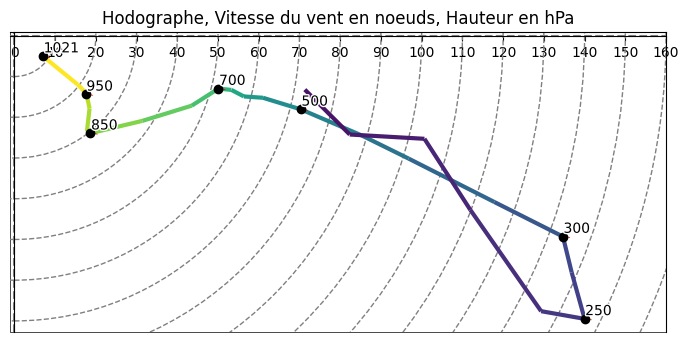

In [7]:
# Tracer un Hodographe à l'aide de la librairie Metpy.

fig = plt.figure(figsize=(7, 7), tight_layout=True)
ax = fig.add_subplot(1, 1, 1)

# Valeurs du niveau de pression à afficher sur l'hodographe si elles
# sont présentes. Vous pouvez en ajouter ou en supprimer à votre guise.
boundaries_default = [950, 850, 700, 500, 300, 250]

# Toujours afficher le premier niveau de pression.
boundaries_p = [p[0].magnitude]

# Afficher également tous ceux de la liste ci-dessus, mais seulement s'ils sont plus hauts que
# le premier niveau de pression et sont au moins 50mbar au-dessus du premier niveau de pression.
# Par exemple, si le premier niveau de pression est à 855mbar, ne pas afficher 950 ni 850.
boundaries_p.extend([bd for bd in boundaries_default if ((boundaries_p[0]-bd)>=50 and bd>=p[-1].magnitude)])
boundaries_p *= units.hPa
u_pts, v_pts = mpinterpolate.interpolate_1d(boundaries_p, p, u, v)
boundaries_p[0] = round(boundaries_p[0])

# Ajouter les points sur l'hodographe pour les niveaux de pression choisis.
ax.scatter(u_pts, v_pts, c="black", zorder=10)
texts = []
for up, vp, z in zip(u_pts, v_pts, boundaries_p):
    z_str = int(z.magnitude)
    texts.append(ax.text(up, vp, z_str, ha='center', fontsize=10,
                    path_effects=[mpatheffects.withStroke(foreground='white', linewidth=2)],
                    zorder=12)
                )

# Échelle de l'hodographe en fonction de la valeur du vent la plus élevée.
max_range = math.ceil(max(ws).magnitude) + 1
h = Hodograph(ax, component_range=max_range)

if max_range < 50:
    inc = math.ceil(max_range / 10)
else:
    inc = 5 * math.ceil(max_range / 100)

# Ajouter des axes au centre du graphique.
ax.spines['left'].set_position('zero')
ax.spines['bottom'].set_position('zero')
ax.patch.set_edgecolor('black')
ax.patch.set_linewidth(0.5)

# Ajouter une couleur qui change en fonction des niveaux de pression.
h.plot_colormapped(u, v, p)

# Redimensionner l'hodographe pour zoomer là où se trouvent les valeurs.
# Commentez h.ax.autoscale() si vous voulez l'hodographe entier à la place.
h.ax.autoscale()
bottom, top = h.ax.get_ylim()
left, right = h.ax.get_xlim()

# Ajouter les lignes de la grille pour les vitesses de vent.
h.add_grid(increment=inc)

# S'assurer que les axes restent à l'intérieur du graphique si les vents sont tous très éloignés dans une direction.
if left > 0:
    left = -1
if bottom > 0:
    bottom = -1
if right < 0:
    right = 1
if top < 0:
    top = 1

# Redimensionner l'hodographe pour zoomer sur le graphique,
# mais n'afficher que les valeurs d'axe sur l'axe le plus long
# et ajouter un petit tampon pour s'assurer que l'ensemble du
# tracé reste toujours visible.
norm_bottom = abs(bottom)
norm_left = abs(left)
whole, remainder = divmod(max_range, inc)
highest = max(norm_bottom, top, norm_left, right)
if highest in (norm_bottom, top):
    if highest == norm_bottom:
        norm_bottom = (whole + math.ceil(remainder/inc)) * inc
    else:
        top = (whole + math.ceil(remainder/inc)) * inc
    ax.set_ylim(bottom=-norm_bottom, top=top)
    ax.set_xlim(left=-norm_left, right=right)
    
    ax.yaxis.set_major_locator(mticker.MultipleLocator(inc))
    ticks_loc_y = ax.get_yticks().tolist()
    ax.yaxis.set_major_locator(mticker.FixedLocator(ticks_loc_y))
    ax.set_yticklabels([f'{abs(int(y))}' for y in ticks_loc_y])
    ax.set_xticks([])
else:
    if highest == norm_left:
        norm_left = (whole + math.ceil(remainder/inc)) * inc
    else:
        right = (whole + math.ceil(remainder/inc)) * inc
    ax.set_ylim(bottom=-norm_bottom, top=top)
    ax.set_xlim(left=-norm_left, right=right)
    
    ax.xaxis.set_major_locator(mticker.MultipleLocator(inc))
    ticks_loc_x = ax.get_xticks().tolist()
    ax.xaxis.set_major_locator(mticker.FixedLocator(ticks_loc_x))
    ax.set_xticklabels([f'{abs(int(x))}' for x in ticks_loc_x])
    ax.set_yticks([])

# Supprimer les étiquettes car les axes sont au milieu du graphique.
ax.set_xlabel('')
ax.set_ylabel('')

h.ax.title.set_text('Hodographe, Vitesse du vent en noeuds, Hauteur en hPa')

# Veiller à ce que le texte des points dans l'hodographe ne se chevauchent pas.
adjust_text(texts, arrowprops=dict(arrowstyle='->', color='r', lw=0.5), expand_text=(1.8, 1.8))

# Utiliser plt.show() ou plt.savefig('nom.png') en dehors d'un Jupyter Notebook.
display(fig)

Enfin, nous avons également obtenu les indices de convection du ``Processus`` et nous avons déjà arrangé les données pour qu'elles puissent être affichées sous forme de tableau, c'est donc ce que nous allons faire!

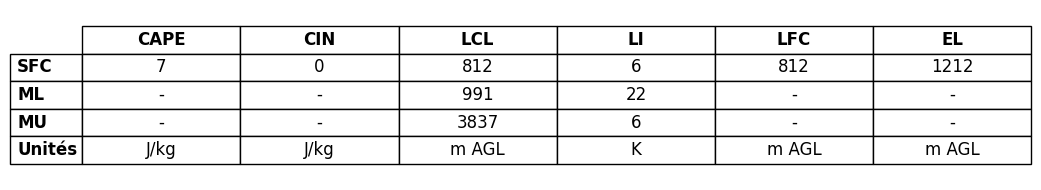

In [8]:
# Traçage du tableau des indices de convection.

fig = plt.figure(figsize=(12, 2), tight_layout=True)
table_ax = fig.add_subplot(1, 1, 1)
table_ax.axis('tight')
table_ax.axis('off')

# Nom des colonnes et des lignes du tableau.
col_names = ['CAPE', 'CIN', 'LCL', 'LI', 'LFC', 'EL']
row_names = ['SFC', 'ML', 'MU', 'Unités']
tab = table_ax.table(cellText=conv_indices, colLabels=col_names, rowLabels=row_names, loc='center', cellLoc='center')

# Modifier la taille et l'échelle de la police du tableau pour améliorer la lisibilité.
tab.auto_set_font_size(False)
tab.set_fontsize(12)
tab.scale(1.5, 1.5)

# Remplir le tableau.
for (row, col), cell in tab.get_celld().items():
    # Mettre les titres des lignes et des colonnes en gras.
    if (row == 0) or (col == -1):
        cell.set_text_props(fontproperties=FontProperties(size=12, weight='bold'))

# Utiliser plt.show() ou plt.savefig('nom.png') en dehors d'un Jupyter Notebook.
display(fig)

## Conclusion

Grâce à cet outil, Gerald pourra obtenir les informations de radiosondage dont il a besoin en utilisant les données canadiennes. Après avoir lu cet exemple de cas d'utilisation, vous devriez être en mesure d'utiliser la programmation Python pour accéder à un service WMS et l'interroger, créer des requêtes temporelles et afficher les résultats à l'aide de graphiques et de tableaux de données. Vous pouvez adapter cet exemple à vos besoins en modifiant les paramètres de la requête et les étapes du traitement des données.